In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, KAN
from neuralforecast.losses.pytorch import MAE
import torch.optim as optim

from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    r2_score,
)

In [17]:
# -------------------------------
# 2. Data Loading and Preparation
# -------------------------------
state = "SA"
df = pd.read_csv(
    f"../data/featurised/{state}_test_final.csv", parse_dates=["SETTLEMENTDATE"]
)
print(df.columns)
rrp_median = df["rrp_median"].values[0]
rrp_mad = df["rrp_mad"].values[0]

# Rename columns to fit Nixtla's requirements
df.rename(
    columns={
        "SETTLEMENTDATE": "ds",
        "asinh_RRP": "y",
    },
    inplace=True,
)

# Add a unique_id column
df["unique_id"] = f"{state}"

exog_cols = [
    "asinh_RRP_lag_168",
    "TOTALDEMAND",
    "NETINTERCHANGE",
    "SS_SOLAR_UIGF",
    "SS_WIND_UIGF",
    "tempC",
    "is_weekend",
]

req_cols = ["unique_id", "ds", "y"]

# Reorder columns
df = df[req_cols + exog_cols]

# Sort by unique_id and ds
df.sort_values(by=["unique_id", "ds"], inplace=True)

# Set the correct hourly frequency
df.set_index("ds", inplace=True)
df = df.asfreq("h").reset_index()

df.head()

Index(['SETTLEMENTDATE', 'TOTALDEMAND', 'RRP', 'REGION', 'tempC', 'FeelsLikeC',
       'humidity', 'windspeedKmph', 'WindGustKmph', 'cloudcover',
       'SS_SOLAR_UIGF', 'SS_WIND_UIGF', 'NETINTERCHANGE', 'hour', 'dayofweek',
       'month', 'is_weekend', 'is_holiday', 'rrp_median', 'rrp_mad',
       'asinh_RRP', 'RRP_lag_1', 'asinh_RRP_lag_1', 'TOTALDEMAND_lag_1',
       'RRP_lag_24', 'asinh_RRP_lag_24', 'TOTALDEMAND_lag_24', 'RRP_lag_48',
       'asinh_RRP_lag_48', 'TOTALDEMAND_lag_48', 'RRP_lag_72',
       'asinh_RRP_lag_72', 'TOTALDEMAND_lag_72', 'RRP_lag_96',
       'asinh_RRP_lag_96', 'TOTALDEMAND_lag_96', 'RRP_lag_120',
       'asinh_RRP_lag_120', 'TOTALDEMAND_lag_120', 'RRP_lag_144',
       'asinh_RRP_lag_144', 'TOTALDEMAND_lag_144', 'RRP_lag_168',
       'asinh_RRP_lag_168', 'TOTALDEMAND_lag_168', 'hour_sin', 'hour_cos'],
      dtype='object')


,ds,unique_id,y,asinh_RRP_lag_168,TOTALDEMAND,NETINTERCHANGE,SS_SOLAR_UIGF,SS_WIND_UIGF,tempC,is_weekend
0,2024-04-08 00:00:00,SA,0.324432,0.702110,1355.229167,-547.766667,0.0,150.480333,12,0
1,2024-04-08 01:00:00,SA,0.176021,0.751034,1308.473333,-537.156667,0.0,157.059537,12,0
2,2024-04-08 02:00:00,SA,0.156403,0.596502,1239.450000,-564.015833,0.0,150.756383,12,0
3,2024-04-08 03:00:00,SA,0.158788,0.194691,1188.648333,-561.810000,0.0,109.051492,12,0
4,2024-04-08 04:00:00,SA,0.540115,0.281071,1188.428333,-563.981667,0.0,97.732288,12,0


In [ ]:
# Validation period
forecast_start, forecast_end = "2025-02-22 00:00:00", "2025-02-28 23:00:00"
# Week 1
# forecast_start, forecast_end = "2025-03-01 00:00:00", "2025-03-07 23:00:00"
# Week 2
# forecast_start, forecast_end = "2025-03-08 00:00:00", "2025-03-14 23:00:00"
# Week 3
# forecast_start, forecast_end = "2025-03-15 00:00:00", "2025-03-21 23:00:00"
# Week 4
# forecast_start, forecast_end = "2025-03-22 00:00:00", "2025-03-28 23:00:00"

Y_train_df = df[df.ds < forecast_start].copy()
Y_test_df = df[(df.ds >= forecast_start) & (df.ds <= forecast_end)].copy()

# Print diagnostics
print(f"df shape: {df.shape}")
print(f"Y_train_df shape: {Y_train_df.shape}")
print(f"Y_test_df shape: {Y_test_df.shape}\n")
print(f"Y_train_df unique: {Y_train_df['unique_id'].unique()}")
print(f"Y_test_df unique: {Y_test_df['unique_id'].unique()}\n")
print(f"Y_train_df date (min, max): {Y_train_df['ds'].min(), Y_train_df['ds'].max()}")
print(f"Y_test_df date (min, max): {Y_test_df['ds'].min(), Y_test_df['ds'].max()}\n")

val_len = 24 * 7 * 4  # 4 weeks
print(f"Validation length: {val_len}")
print()

df shape: (8592, 10)
Y_train_df shape: (8352, 10)
Y_test_df shape: (168, 10)

Y_train_df unique: ['SA']
Y_test_df unique: ['SA']

Y_train_df date (min, max): (Timestamp('2024-04-08 00:00:00'), Timestamp('2025-03-21 23:00:00'))
Y_test_df date (min, max): (Timestamp('2025-03-22 00:00:00'), Timestamp('2025-03-28 23:00:00'))

Validation length: 672



In [19]:
new_df = pd.read_csv(
    f"../data/featurised/{state}_test_final.csv", parse_dates=["SETTLEMENTDATE"]
)

# Extract the actual RRP values from the filtered reference DataFrame
y_true = new_df.loc[
    (new_df["SETTLEMENTDATE"] >= forecast_start)
    & (new_df["SETTLEMENTDATE"] <= forecast_end),
    "RRP",
].values

In [20]:
def lstm_hp_tuning(layers, size, opt_class):
    nf = NeuralForecast(
        models=[
            LSTM(
                h=168,
                input_size=336,
                loss=MAE(),
                scaler_type="minmax",
                encoder_n_layers=layers,
                encoder_hidden_size=size,
                decoder_hidden_size=size,
                decoder_layers=layers,
                max_steps=250,
                futr_exog_list=exog_cols,
                early_stop_patience_steps=50,
                recurrent=False,
                optimizer=opt_class,
                random_seed=42,
            ),
        ],
        freq="h",
    )

    nf.fit(df=Y_train_df, val_size=val_len)

    forecasts = nf.predict(futr_df=Y_test_df)

    return forecasts

In [21]:
hp_forecasts = lstm_hp_tuning(3, 64, optim.Adam)
hp_forecasts["LSTM_RRP"] = np.sinh(hp_forecasts["LSTM"].values) * rrp_mad + rrp_median
mae = mean_absolute_error(y_true, hp_forecasts["LSTM_RRP"].values)
print(f"MAE: {mae:.4f}")
# MAE: 23.6497, val week (VIC)
# VIC week1 MAE: 26.8169
# VIC week2 MAE: 20.9682
# VIC week3 MAE: 41.5858
# VIC week4 MAE: 20.5991
# NSW week1 MAE: 35.9167
# NSW week2 MAE: 27.7448
# NSW week3 MAE: 68.1058
# NSW week4 MAE: 17.3979
# QLD week1 MAE: 19.9766
# QLD week2 MAE: 29.9054
# QLD week3 MAE: 20.0206
# QLD week4 MAE: 18.1820
# SA week1 MAE: 28.5244
# SA week2 MAE: 40.1514
# SA week3 MAE: 33.2857
# SA week4 MAE: 30.6161
# TAS week1 MAE: 32.9749

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 85.5 K | train
4 | mlp_decoder  | MLP           | 8.8 K  | train
-------------------------------------------------------
94.3 K    Trainable params
0         Non-trainable params
94.3 K    Total params
0.377     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=250` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 35.4747


In [ ]:
layers = [1, 2, 3]
sizes = [32, 64, 128]
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
combinations = len(layers) * len(sizes) * len(optimizers)
lstm_results = []

for layer in layers:
    for size in sizes:
        for opt in optimizers:
            print(f"Testing with {layer} layers, {size} size, {opt.__name__} optimizer")
            forecasts = lstm_hp_tuning(layer, size, opt)
            forecasts["LSTM_RRP"] = (
                np.sinh(forecasts["LSTM"].values) * rrp_mad + rrp_median
            )
            mae = mean_absolute_error(y_true, forecasts["LSTM_RRP"].values)
            print(f"MAE: {mae}")
            lstm_results.append((layer, size, opt.__name__, mae))
            print(
                f"Results so far: {len(lstm_results)} combinations tested out of {combinations}\n"
            )

In [1]:
lstm_results = [
    (1, 32, "Adam", 23.649653345094492),
    (1, 32, "SGD", 62.25595607499841),
    (1, 32, "RMSprop", 22.937449826573427),
    (1, 64, "Adam", 26.042132524741355),
    (1, 64, "SGD", 81.6366735260547),
    (1, 64, "RMSprop", 28.669553439303225),
    (1, 128, "Adam", 23.01071149410791),
    (1, 128, "SGD", 64.9220759715746),
    (1, 128, "RMSprop", 24.91296066148314),
    (2, 32, "Adam", 24.845198950478512),
    (2, 32, "SGD", 77.40126450452189),
    (2, 32, "RMSprop", 27.934915431980794),
    (2, 64, "Adam", 22.304275431612204),
    (2, 64, "SGD", 64.09169128172869),
    (2, 64, "RMSprop", 22.05224406196142),
    (2, 128, "Adam", 23.29421121758939),
    (2, 128, "SGD", 71.08089078190172),
    (2, 128, "RMSprop", 23.328344431996726),
    (3, 32, "Adam", 28.559925072889552),
    (3, 32, "SGD", 71.11059832558024),
    (3, 32, "RMSprop", 24.14432512874866),
    (3, 64, "Adam", 21.654326391861172),
    (3, 64, "SGD", 65.2377615283088),
    (3, 64, "RMSprop", 22.955984582906137),
    (3, 128, "Adam", 22.45056271448071),
    (3, 128, "SGD", 69.33218532981132),
    (3, 128, "RMSprop", 25.20065758590406),
]
print("LSTM Results:")


print(lstm_results)

LSTM Results:
[(1, 32, 'Adam', 23.649653345094492), (1, 32, 'SGD', 62.25595607499841), (1, 32, 'RMSprop', 22.937449826573427), (1, 64, 'Adam', 26.042132524741355), (1, 64, 'SGD', 81.6366735260547), (1, 64, 'RMSprop', 28.669553439303225), (1, 128, 'Adam', 23.01071149410791), (1, 128, 'SGD', 64.9220759715746), (1, 128, 'RMSprop', 24.91296066148314), (2, 32, 'Adam', 24.845198950478512), (2, 32, 'SGD', 77.40126450452189), (2, 32, 'RMSprop', 27.934915431980794), (2, 64, 'Adam', 22.304275431612204), (2, 64, 'SGD', 64.09169128172869), (2, 64, 'RMSprop', 22.05224406196142), (2, 128, 'Adam', 23.29421121758939), (2, 128, 'SGD', 71.08089078190172), (2, 128, 'RMSprop', 23.328344431996726), (3, 32, 'Adam', 28.559925072889552), (3, 32, 'SGD', 71.11059832558024), (3, 32, 'RMSprop', 24.14432512874866), (3, 64, 'Adam', 21.654326391861172), (3, 64, 'SGD', 65.2377615283088), (3, 64, 'RMSprop', 22.955984582906137), (3, 128, 'Adam', 22.45056271448071), (3, 128, 'SGD', 69.33218532981132), (3, 128, 'RMSprop'

In [2]:
best_lstm = min(lstm_results, key=lambda x: x[3])
print(f"Best LSTM config: {best_lstm}")

Best LSTM config: (3, 64, 'Adam', 21.654326391861172)


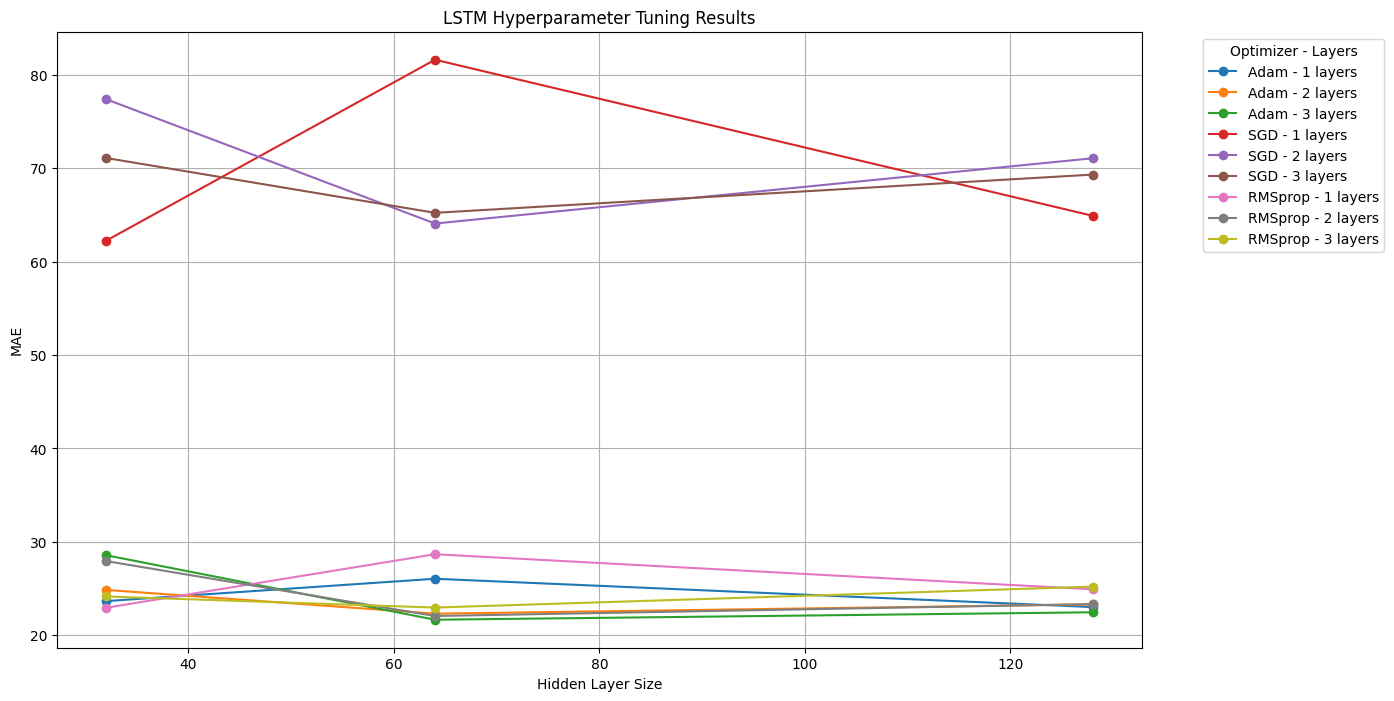

In [5]:
# Convert to DataFrame for easier visualization
df_lstm_results = pd.DataFrame(
    lstm_results, columns=["Layers", "Size", "Optimizer", "MAE"]
)

# Plot the results
plt.figure(figsize=(14, 8))
for optimizer in df_lstm_results["Optimizer"].unique():
    subset = df_lstm_results[df_lstm_results["Optimizer"] == optimizer]
    for layer in subset["Layers"].unique():
        layer_subset = subset[subset["Layers"] == layer]
        plt.plot(
            layer_subset["Size"],
            layer_subset["MAE"],
            marker="o",
            label=f"{optimizer} - {layer} layers",
        )

plt.title("LSTM Hyperparameter Tuning Results")
plt.xlabel("Hidden Layer Size")
plt.ylabel("MAE")
plt.legend(title="Optimizer - Layers", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

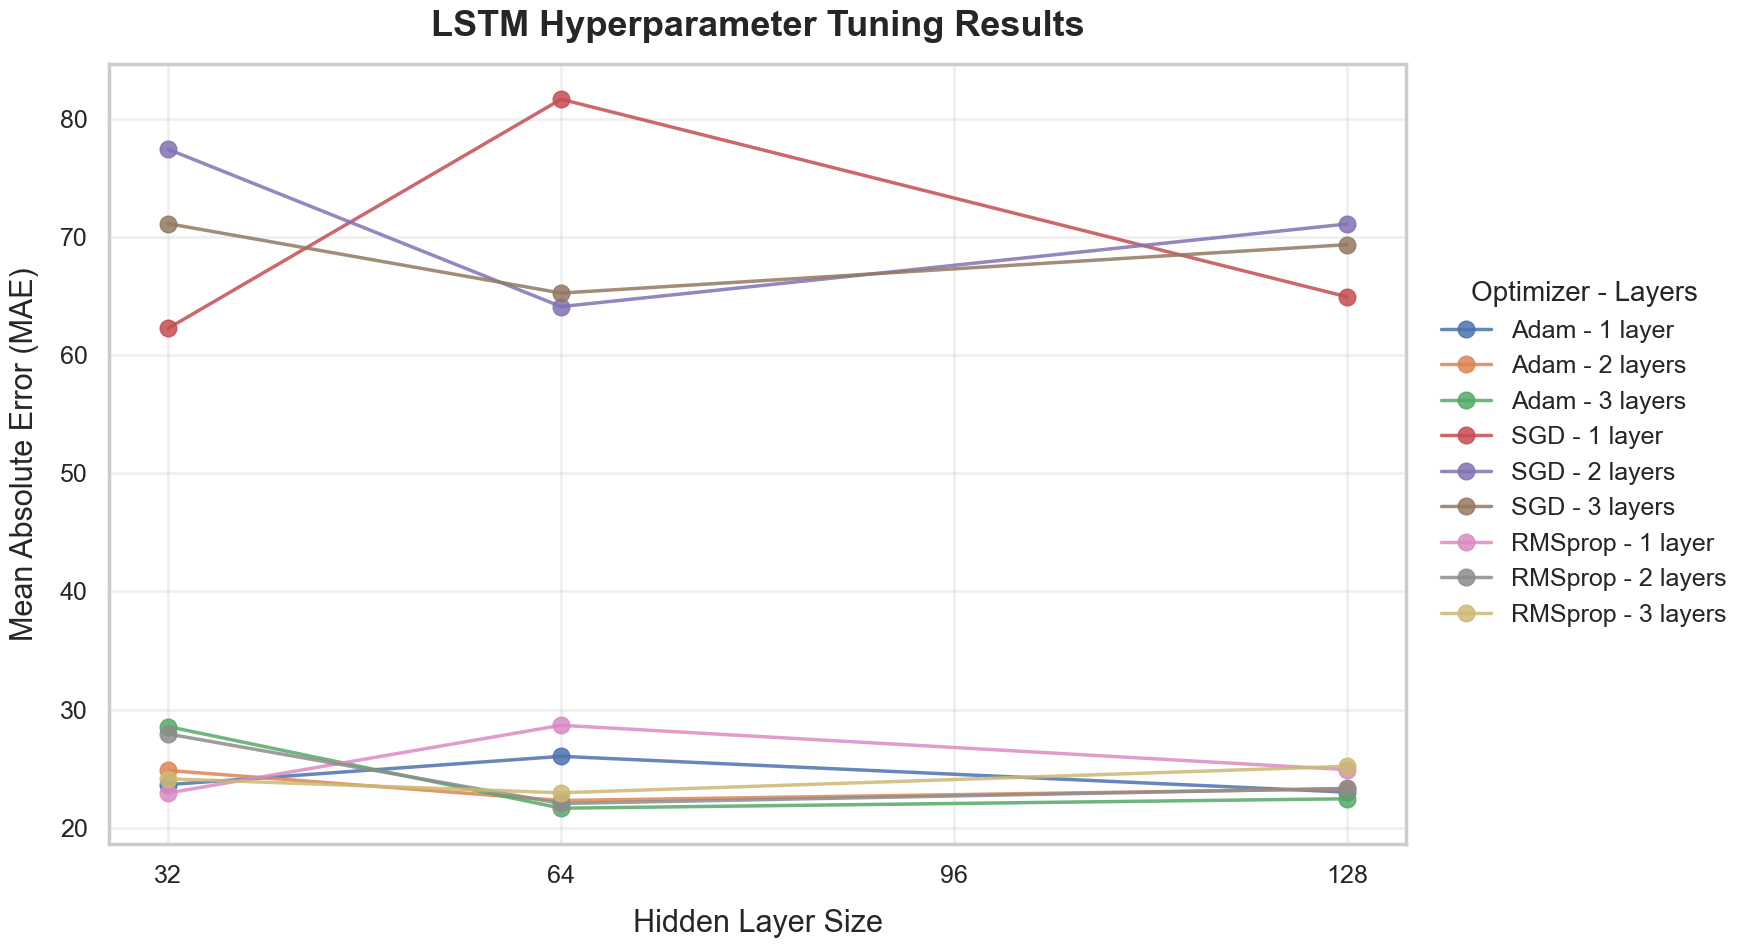

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
df_lstm_results = pd.DataFrame(
    lstm_results, columns=["Layers", "Size", "Optimizer", "MAE"]
)

# Set visual theme and scale
sns.set_theme(style="whitegrid")
sns.set_context("poster")  # Large fonts to match your other plots

# Create figure
plt.figure(figsize=(18, 10))

# Plot for each optimizer and layer combination
for optimizer in df_lstm_results["Optimizer"].unique():
    subset = df_lstm_results[df_lstm_results["Optimizer"] == optimizer]
    for layer in subset["Layers"].unique():
        layer_subset = subset[subset["Layers"] == layer]
        plt.plot(
            layer_subset["Size"],
            layer_subset["MAE"],
            marker="o",
            linewidth=2.5,
            alpha=0.85,
            label=f"{optimizer} - {layer} layer{'s' if layer > 1 else ''}",
        )

# Title and axes
plt.title("LSTM Hyperparameter Tuning Results", fontsize=26, fontweight="bold", pad=20)
plt.xlabel("Hidden Layer Size", fontsize=22, labelpad=15)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=22, labelpad=15)

# Ticks
plt.xticks(ticks=range(32, 129, 32), fontsize=18)  # Set ticks: 32, 64, 96, 128
plt.yticks(fontsize=18)

# Grid
plt.grid(True, alpha=0.3)

# Legend
plt.legend(
    title="Optimizer - Layers",
    fontsize=18,
    title_fontsize=20,
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    frameon=False,
)

# Layout and save
plt.tight_layout()
plt.savefig("lstm_gridsearch_results.png", bbox_inches="tight", dpi=300)
plt.show()

In [2]:
def kan_hp_tuning(layers, grid_size, spline_order):
    # layers, grid_size, spline_order
    nf = NeuralForecast(
        models=[
            KAN(
                h=168,
                input_size=336,
                loss=MAE(),
                n_hidden_layers=layers,
                grid_size=grid_size,
                spline_order=spline_order,
                max_steps=250,
                scaler_type="minmax",
                futr_exog_list=exog_cols,
                early_stop_patience_steps=50,
                random_seed=42,
            ),
        ],
        freq="h",
    )

    nf.fit(df=Y_train_df, val_size=val_len)

    forecasts = nf.predict(futr_df=Y_test_df)

    return forecasts

In [ ]:
# hp_forecasts = kan_hp_tuning(1, 4, 2)
# hp_forecasts["KAN_RRP"] = np.sinh(hp_forecasts["KAN"].values) * rrp_mad + rrp_median
# mae = mean_absolute_error(y_true, hp_forecasts["KAN_RRP"].values)
# print(f"MAE: {mae:.4f}")
# MAE: 39.8219, val week

In [ ]:
layers = [1, 2, 3]
grid_size = [4, 5, 6]
spline_order = [2, 3, 4]
combinations = len(layers) * len(grid_size) * len(spline_order)
kan_results = []

for layer in layers:
    for grid in grid_size:
        for spline in spline_order:
            print(
                f"Testing with {layer} layers, {grid} grid size, spline_order {spline}"
            )
            forecasts = kan_hp_tuning(layer, grid, spline)
            forecasts["KAN_RRP"] = (
                np.sinh(forecasts["KAN"].values) * rrp_mad + rrp_median
            )
            mae = mean_absolute_error(y_true, forecasts["KAN_RRP"].values)
            print(f"MAE: {mae}")
            kan_results.append((layer, grid, spline, mae))
            print(
                f"Results so far: {len(kan_results)} combinations tested out of {combinations}\n"
            )

In [8]:
kan_results = [
    (1, 4, 2, 39.82189579931248),
    (1, 4, 3, 39.797991055163),
    (1, 4, 4, 36.91644537093485),
    (1, 5, 2, 36.7404086559646),
    (1, 5, 3, 35.30330002262837),
    (1, 5, 4, 35.22469400526446),
    (1, 6, 2, 38.14807566847484),
    (1, 6, 3, 35.48905968856804),
    (1, 6, 4, 36.666309315482536),
    (2, 4, 2, 39.83528602172567),
    (2, 4, 3, 39.56133558883363),
    (2, 4, 4, 38.67233449755266),
    (2, 5, 2, 37.13968214634284),
    (2, 5, 3, 37.526087748074076),
    (2, 5, 4, 39.72650992667313),
    (2, 6, 2, 37.6457993970516),
    (2, 6, 3, 37.77873854074445),
    (2, 6, 4, 38.49096935063496),
    (3, 4, 2, 42.34302544424223),
    (3, 4, 3, 40.552766309192606),
    (3, 4, 4, 41.70461798928293),
    (3, 5, 2, 36.09881526604687),
    (3, 5, 3, 36.26069583206179),
    (3, 5, 4, 38.72319530296355),
    (3, 6, 2, 39.93731905839096),
    (3, 6, 3, 43.16015322778456),
    (3, 6, 4, 37.511684518833626),
]
print("KAN Results:")
print(kan_results)

KAN Results:
[(1, 4, 2, 39.82189579931248), (1, 4, 3, 39.797991055163), (1, 4, 4, 36.91644537093485), (1, 5, 2, 36.7404086559646), (1, 5, 3, 35.30330002262837), (1, 5, 4, 35.22469400526446), (1, 6, 2, 38.14807566847484), (1, 6, 3, 35.48905968856804), (1, 6, 4, 36.666309315482536), (2, 4, 2, 39.83528602172567), (2, 4, 3, 39.56133558883363), (2, 4, 4, 38.67233449755266), (2, 5, 2, 37.13968214634284), (2, 5, 3, 37.526087748074076), (2, 5, 4, 39.72650992667313), (2, 6, 2, 37.6457993970516), (2, 6, 3, 37.77873854074445), (2, 6, 4, 38.49096935063496), (3, 4, 2, 42.34302544424223), (3, 4, 3, 40.552766309192606), (3, 4, 4, 41.70461798928293), (3, 5, 2, 36.09881526604687), (3, 5, 3, 36.26069583206179), (3, 5, 4, 38.72319530296355), (3, 6, 2, 39.93731905839096), (3, 6, 3, 43.16015322778456), (3, 6, 4, 37.511684518833626)]


In [9]:
best_kan = min(kan_results, key=lambda x: x[3])
print(f"Best KAN config: {best_kan}")

Best KAN config: (1, 5, 4, 35.22469400526446)


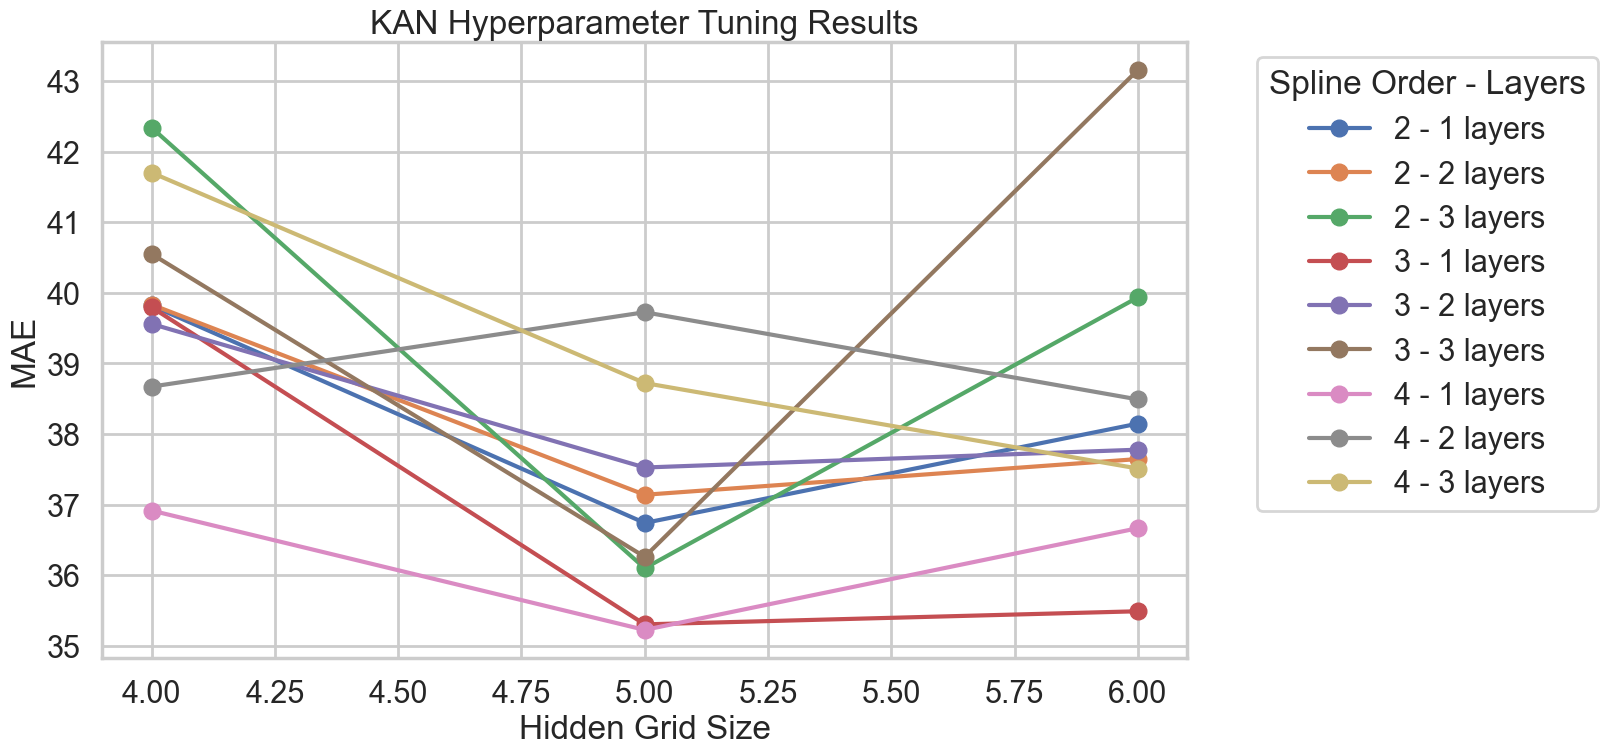

In [10]:
# Convert to DataFrame for easier visualization
df_kan_results = pd.DataFrame(
    kan_results, columns=["Layers", "Grid Size", "Spline Order", "MAE"]
)

# Plot the results
plt.figure(figsize=(14, 8))
for order in df_kan_results["Spline Order"].unique():
    subset = df_kan_results[df_kan_results["Spline Order"] == order]
    for layer in subset["Layers"].unique():
        layer_subset = subset[subset["Layers"] == layer]
        plt.plot(
            layer_subset["Grid Size"],
            layer_subset["MAE"],
            marker="o",
            label=f"{order} - {layer} layers",
        )

plt.title("KAN Hyperparameter Tuning Results")
plt.xlabel("Hidden Grid Size")
plt.ylabel("MAE")
plt.legend(title="Spline Order - Layers", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

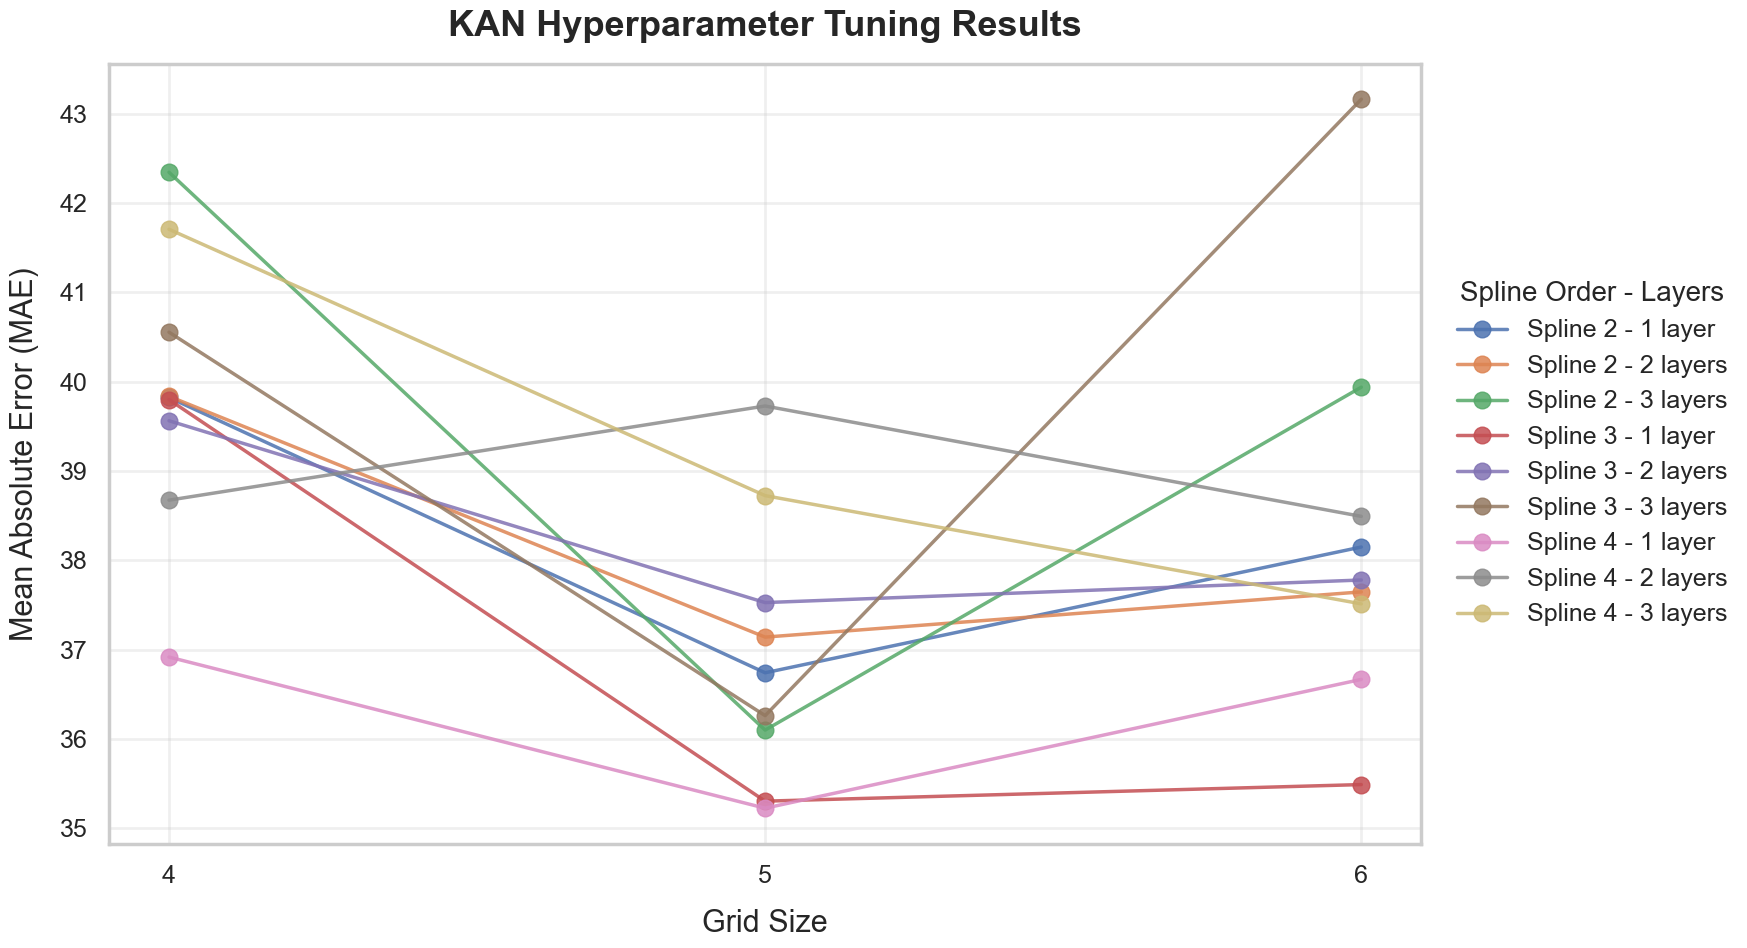

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
df_kan_results = pd.DataFrame(
    kan_results, columns=["Layers", "Grid Size", "Spline Order", "MAE"]
)

# Set theme and font scale
sns.set_theme(style="whitegrid")
sns.set_context("poster")

# Create figure
plt.figure(figsize=(18, 10))

# Plot for each spline order and layer combination
for order in df_kan_results["Spline Order"].unique():
    subset = df_kan_results[df_kan_results["Spline Order"] == order]
    for layer in subset["Layers"].unique():
        layer_subset = subset[subset["Layers"] == layer]
        plt.plot(
            layer_subset["Grid Size"],
            layer_subset["MAE"],
            marker="o",
            linewidth=2.5,
            alpha=0.85,
            label=f"Spline {order} - {layer} layer{'s' if layer > 1 else ''}",
        )

# Title and axes
plt.title("KAN Hyperparameter Tuning Results", fontsize=26, fontweight="bold", pad=20)
plt.xlabel("Grid Size", fontsize=22, labelpad=15)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=22, labelpad=15)

# Ticks
plt.xticks(ticks=range(4, 7), fontsize=18)  # Grid sizes: 4, 5, 6
plt.yticks(fontsize=18)

# Grid and legend
plt.grid(True, alpha=0.3)
plt.legend(
    title="Spline Order - Layers",
    fontsize=18,
    title_fontsize=20,
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    frameon=False,
)

# Final layout and save
plt.tight_layout()
plt.savefig("kan_gridsearch_results.png", bbox_inches="tight", dpi=300)
plt.show()

In [3]:
# -------------------------------
# 2. Data Loading and Preparation
# -------------------------------
state = "VIC"
df = pd.read_csv(
    f"../data/featurised/{state}_test_final.csv", parse_dates=["SETTLEMENTDATE"]
)
print(df.columns)
rrp_median = df["rrp_median"].values[0]
rrp_mad = df["rrp_mad"].values[0]

# Rename columns to fit Nixtla's requirements
df.rename(
    columns={
        "SETTLEMENTDATE": "ds",
        "asinh_RRP": "y",
    },
    inplace=True,
)

# Add a unique_id column
df["unique_id"] = f"{state}"

exog_cols = [
    "asinh_RRP_lag_168",
    "TOTALDEMAND",
    "NETINTERCHANGE",
    "SS_SOLAR_UIGF",
    "SS_WIND_UIGF",
    "tempC",
]

req_cols = ["unique_id", "ds", "y"]

# Reorder columns
df = df[req_cols + exog_cols]

# Sort by unique_id and ds
df.sort_values(by=["unique_id", "ds"], inplace=True)

# Set the correct hourly frequency
df.set_index("ds", inplace=True)
df = df.asfreq("h").reset_index()

df.head()

Index(['SETTLEMENTDATE', 'TOTALDEMAND', 'RRP', 'REGION', 'tempC', 'FeelsLikeC',
       'humidity', 'windspeedKmph', 'WindGustKmph', 'cloudcover',
       'SS_SOLAR_UIGF', 'SS_WIND_UIGF', 'NETINTERCHANGE', 'hour', 'dayofweek',
       'month', 'is_weekend', 'is_holiday', 'rrp_median', 'rrp_mad',
       'asinh_RRP', 'RRP_lag_1', 'asinh_RRP_lag_1', 'TOTALDEMAND_lag_1',
       'RRP_lag_24', 'asinh_RRP_lag_24', 'TOTALDEMAND_lag_24', 'RRP_lag_48',
       'asinh_RRP_lag_48', 'TOTALDEMAND_lag_48', 'RRP_lag_72',
       'asinh_RRP_lag_72', 'TOTALDEMAND_lag_72', 'RRP_lag_96',
       'asinh_RRP_lag_96', 'TOTALDEMAND_lag_96', 'RRP_lag_120',
       'asinh_RRP_lag_120', 'TOTALDEMAND_lag_120', 'RRP_lag_144',
       'asinh_RRP_lag_144', 'TOTALDEMAND_lag_144', 'RRP_lag_168',
       'asinh_RRP_lag_168', 'TOTALDEMAND_lag_168', 'hour_sin', 'hour_cos'],
      dtype='object')


,ds,unique_id,y,asinh_RRP_lag_168,TOTALDEMAND,NETINTERCHANGE,SS_SOLAR_UIGF,SS_WIND_UIGF,tempC
0,2024-04-08 00:00:00,VIC,0.174880,-0.262037,4240.857500,1217.049167,0.0,419.660486,15
1,2024-04-08 01:00:00,VIC,0.059877,-0.243088,4004.164167,1245.216667,0.0,389.454063,14
2,2024-04-08 02:00:00,VIC,-0.015636,-0.351827,3818.462500,1262.740000,0.0,352.348220,14
3,2024-04-08 03:00:00,VIC,0.035303,-0.546972,3757.208333,1225.508333,0.0,302.614793,13
4,2024-04-08 04:00:00,VIC,0.030878,-0.627017,3796.150000,1239.477500,0.0,333.293046,13


In [4]:
# Validation period
# forecast_start, forecast_end = "2025-02-22 00:00:00", "2025-02-28 23:00:00"
# Week 1
forecast_start, forecast_end = "2025-03-01 00:00:00", "2025-03-07 23:00:00"
# Week 2
# forecast_start, forecast_end = "2025-03-08 00:00:00", "2025-03-14 23:00:00"
# Week 3
# forecast_start, forecast_end = "2025-03-15 00:00:00", "2025-03-21 23:00:00"
# Week 4
# forecast_start, forecast_end = "2025-03-22 00:00:00", "2025-03-28 23:00:00"

Y_train_df = df[df.ds < forecast_start].copy()
Y_test_df = df[(df.ds >= forecast_start) & (df.ds <= forecast_end)].copy()

# Print diagnostics
print(f"df shape: {df.shape}")
print(f"Y_train_df shape: {Y_train_df.shape}")
print(f"Y_test_df shape: {Y_test_df.shape}\n")
print(f"Y_train_df unique: {Y_train_df['unique_id'].unique()}")
print(f"Y_test_df unique: {Y_test_df['unique_id'].unique()}\n")
print(f"Y_train_df date (min, max): {Y_train_df['ds'].min(), Y_train_df['ds'].max()}")
print(f"Y_test_df date (min, max): {Y_test_df['ds'].min(), Y_test_df['ds'].max()}\n")

val_len = 24 * 7 * 4  # 4 weeks
print(f"Validation length: {val_len}")
print()

df shape: (8592, 9)
Y_train_df shape: (7848, 9)
Y_test_df shape: (168, 9)

Y_train_df unique: ['VIC']
Y_test_df unique: ['VIC']

Y_train_df date (min, max): (Timestamp('2024-04-08 00:00:00'), Timestamp('2025-02-28 23:00:00'))
Y_test_df date (min, max): (Timestamp('2025-03-01 00:00:00'), Timestamp('2025-03-07 23:00:00'))

Validation length: 672



In [5]:
new_df = pd.read_csv(
    f"../data/featurised/{state}_test_final.csv", parse_dates=["SETTLEMENTDATE"]
)

# Extract the actual RRP values from the filtered reference DataFrame
y_true = new_df.loc[
    (new_df["SETTLEMENTDATE"] >= forecast_start)
    & (new_df["SETTLEMENTDATE"] <= forecast_end),
    "RRP",
].values

In [ ]:
hp_forecasts = kan_hp_tuning(1, 5, 4)
hp_forecasts["KAN_RRP"] = np.sinh(hp_forecasts["KAN"].values) * rrp_mad + rrp_median
mae = mean_absolute_error(y_true, hp_forecasts["KAN_RRP"].values)
print(f"MAE: {mae:.4f}")
# MAE: 39.8219, val week
# VIC week1 MAE: 27.3334
# VIC week2 MAE: 27.3323
# VIC week3 MAE: 28.9541
# VIC week4 MAE: 25.4814

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | layers       | ModuleList    | 19.9 M | train
-------------------------------------------------------
19.9 M    Trainable params
0         Non-trainable params
19.9 M    Total params
79.479    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=250` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 27.3334
